In [271]:
import results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

sns.set(style = "whitegrid", rc = {
   "legend.frameon": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": "Helvetica",
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.labelsize": 16,
    'legend.fontsize': 12
})


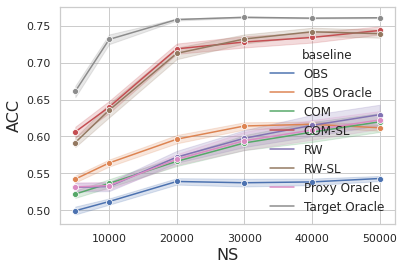

In [282]:
df, meandf  = results.get_erm_convergence_result_df('NR_erm_convergence_rates_crossfit_oracle_R10')

df = df[df['alpha_0'] != 0.2]
df.reset_index(inplace=True)
fig = sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')

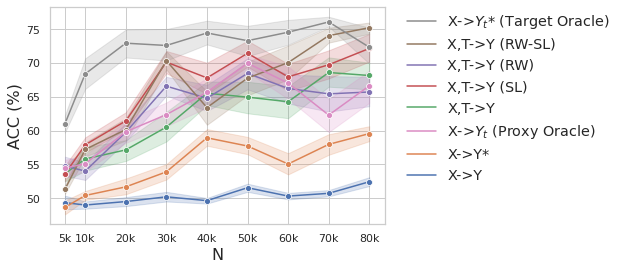

In [107]:
df, meandf  = results.get_erm_convergence_result_df('erm_convergence_rates_no_crossfit_beta3_alpha1_R15')
df['ACC']= df['ACC']*100
df.reset_index(inplace=True)

fig = sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')
fig.set_xlabel('N')
fig.set_ylabel('ACC (%)')

handles, labels = plt.gca().get_legend_handles_labels()

disp_names = {
    'Target Oracle': 'X->$Y_t$* (Target Oracle)',
    'RW-SL': 'X,T->Y (RW-SL)',
    'COM-SL': 'X,T->Y (SL)',
    'COM': 'X,T->Y',
    'RW': 'X,T->Y (RW)',
    'Proxy Oracle': 'X->$Y_t$ (Proxy Oracle)',
    'OBS Oracle': 'X->Y*',
    'OBS': 'X->Y'
}
order = [7,5,4,3,2,6,1,0]
plt.legend([handles[idx] for idx in order],[disp_names[labels[idx]] for idx in order],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

fig.set_xticks([5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], labels=['5k', '10k', '20k', '30k', '40k', '50k', '60k', '70k', '80k'])


In [27]:
df['alpha_error'] = df['alpha_0'] - df['alpha_0_hat']
df['beta_error'] = df['beta_0'] - df['beta_0_hat']
df.groupby(['baseline', 'NS']).mean().to_csv('baselines.csv')

## Experimental study dataset results

In [293]:
# NR_erm_ohie_crossfit_oracle_params_R10
results = []
for f in glob.glob(f'results/NR_erm_jobs_crossfit_oracle_params_R10_nm/*TE.csv'):
    results.append(pd.read_csv(f))
nsdf = pd.concat(results)
nsdf.drop(columns=['Unnamed: 0'], inplace=True)

nsdf['ate_error'] = nsdf['ate_hat'] - nsdf['ate']
nsdf['param'] = "(" + nsdf['alpha_0'].astype(str)+"," +nsdf['beta_0'].astype(str) + ")"

jobs = nsdf[nsdf['benchmark'] == 'jobs']
ohie = nsdf[nsdf['benchmark'] == 'ohie']
jobs = jobs.sort_values('alpha_0', ascending=True).reset_index(drop=True)
ohie = ohie.sort_values('alpha_0', ascending=True).reset_index(drop=True)

In [294]:
def plot_experimental_data_results(df, metric):
    plt.figure(figsize=(12, 6))
    g = sns.barplot(data=df, x='baseline', y=metric, hue='param', ci=68, errwidth=2)
    plt.xlabel("")
    
    ylabel = "MSE ATE" if metric == "ate_error" else "Policy Risk"
    
    plt.ylabel(ylabel)
    plt.legend( title=r"         ($\alpha, \beta$)")
#     models = ['X -> Y', 'X,T->Y (RW-SL)', 'X->$Y_t$* (Target Oracle)','X->Y*', 'X,T->Y', 'X,T->Y (SL)', 'X,T->Y (RW)', 'X->$Y_t$ (Proxy Oracle)']
#     g.set_xticks(range(len(models)), models, size=12)
#     plt.xticks(rotation=45)


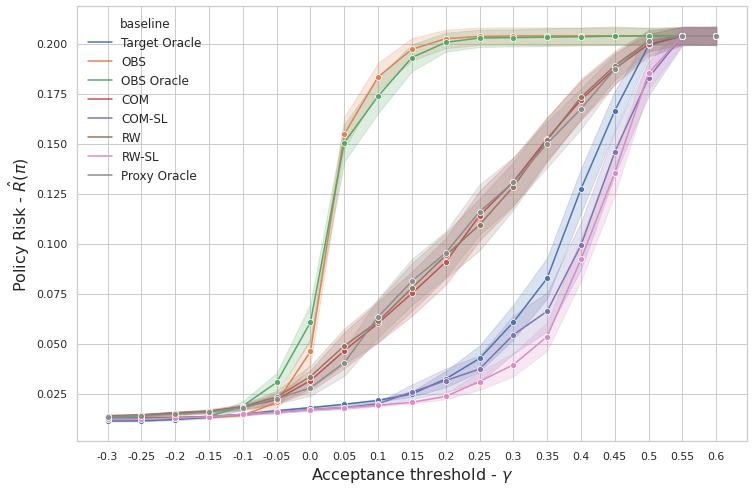

In [310]:
gamma_settings = [i for i in jobs if 'pr_' in i]
pr_results = ['baseline'] + gamma_settings
gammadf = jobs[pr_results].melt(id_vars=['baseline'], var_name="gamma", value_name='policy_risk')

plt.figure(figsize=(12,8))
fig = sns.lineplot(data=gammadf, x='gamma', hue='baseline', y='policy_risk', marker='o', ci=68)

plt.xlabel('Acceptance threshold - $\gamma$')
plt.ylabel('Policy Risk - $\hat{R}(\pi)$')

fig.set_xticks([i for i in range(len(gamma_settings))], labels=[float(i.split('_')[1]) for i in gamma_settings])



In [308]:
[float(i.split('_')[1]) for i in gamma_settings]

[-0.3,
 -0.25,
 -0.2,
 -0.15,
 -0.1,
 -0.05,
 0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6]

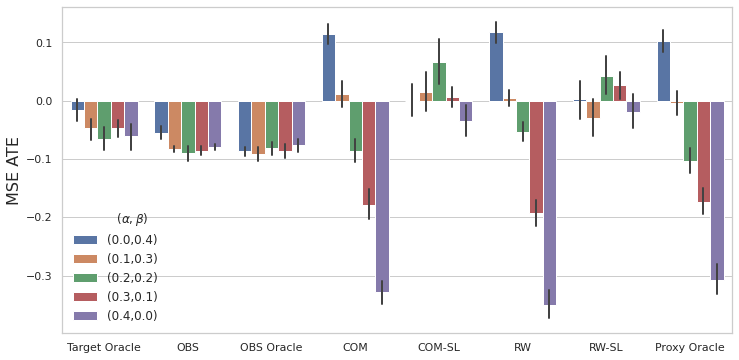

In [295]:
plot_experimental_data_results(jobs, 'ate_error')

Text(0, 0.5, 'Policy risk')

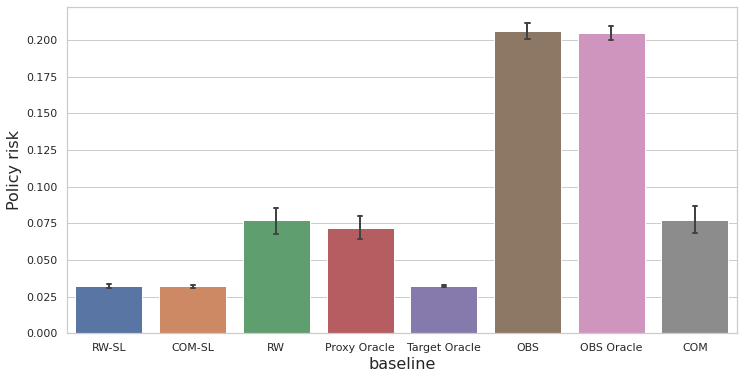

In [217]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data=jobs, x='baseline', y="pr_0.2", ci=68, errwidth=2, capsize=.05)

plt.ylabel("Policy risk")
